# Prepare selenium webdriver

In [1]:
from selenium.webdriver.common.by import By
from selenium import webdriver

def get_driver(is_headless=False):
    user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36"
    chrome_options = webdriver.ChromeOptions()
    if is_headless:
        chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument(f"--user-agent={user_agent}")
    driver = webdriver.Chrome(options=chrome_options)
    driver.implicitly_wait(5)
    return driver

In [2]:
# init variables
driver = get_driver()
egg_list = []

# Start web scrap the egg items of No Frills

In [3]:
# No Frills
url = 'https://www.nofrills.ca/search?search-bar=egg'
driver.get(url)

In [4]:
result_grid = driver.find_element(By.CSS_SELECTOR, 'ul.product-tile-group__list')
items = result_grid.find_elements(By.CSS_SELECTOR, 'li.product-tile-group__list__item')

# store items details of No Frills in egg_list
for item in items:
    brand = item.find_element(By.CSS_SELECTOR, '.product-name__item--brand').text
    title = item.find_element(By.CSS_SELECTOR, '.product-name__item--name').text
    price = item.find_element(By.CSS_SELECTOR, '.selling-price-list__item .price__value').text
    unit_price = item.find_element(By.CSS_SELECTOR, '.comparison-price-list__item .price__value').text
    unit = item.find_element(By.CSS_SELECTOR, '.comparison-price-list__item .price__unit').text
    if 'ea' in unit:
        egg_list.append({
            'brand': brand,
            'title': title,
            'price': price,
            'unit_price': unit_price,
            'unit': unit,
            'merchant': 'No Frills'
        })

# Start web scrap the egg items of Food Basic

In [5]:
# function for breaking down item details of food basic
def get_item_details(item):
    brand = item.find_element(By.CSS_SELECTOR, '.head__brand').text
    title = item.find_element(By.CSS_SELECTOR, '.head__title').text
    price = item.find_element(By.CSS_SELECTOR, '.content__pricing > div').get_attribute('data-main-price')    
    unit_price = item.find_element(By.CSS_SELECTOR, '.pricing__secondary-price > span').text
    unit = item.find_element(By.CSS_SELECTOR, '.pricing__secondary-price abbr').text

    if 'un.' in unit:      
        return {
            'brand': brand,
            'title': title,
            'price': price,
            'unit_price': unit_price,
            'unit': unit,
            'merchant': 'Food Basic'
        }
    
    return None

In [6]:
# food basic
url = 'https://www.foodbasics.ca/search?sortOrder=relevance&filter=egg%3Arelevance%3Acategory%3A000008'
driver.get(url)

result_grid = driver.find_element(By.CSS_SELECTOR, '.products-search--grid.searchOnlineResults')
items = result_grid.find_elements(By.CSS_SELECTOR, '.default-product-tile.tile-product')

for item in items:
    egg = get_item_details(item)
    if egg:
        egg_list.append(egg)

# Go to page 2
url = driver.find_element(By.XPATH, '//*[@id="content-temp"]/div/div[4]/div[4]/div/div/a[3]').get_attribute('href')
driver.get(url)

result_grid = driver.find_element(By.CSS_SELECTOR, '.products-search--grid.searchOnlineResults')
items = result_grid.find_elements(By.CSS_SELECTOR, '.default-product-tile.tile-product')

for item in items:
    egg = get_item_details(item)
    if egg:
        egg_list.append(egg)        

In [7]:
# Close the browser to release resources
driver.quit()

# Load the egg items from website to pandas dataframe

In [8]:
import pandas as pd
import re

# Load to pandas
df = pd.DataFrame.from_records(egg_list)
# Check the loaded items
df.head()

,brand,title,price,unit_price,unit,merchant
0,No Name,Large Grade A Eggs,$3.79,$0.32,/ 1ea,No Frills
1,No Name,Large Size Eggs,$9.29,$0.31,/ 1ea,No Frills
2,President's Choice,Free Run Brown Eggs Large,$6.99,$0.58,/ 1ea,No Frills
3,Burnbrae Farms,Grade A Large Eggs,$6.69,$0.37,/ 1ea,No Frills
4,No Name,Grade A Extra Large Eggs,$4.49,$0.37,/ 1ea,No Frills


In [9]:
df.index = df.index + 1
df.unit = 'ea'

# remove $ or any other characters from price
def get_price(x):
    try:
        reg_result = re.search(r'\$(\d+\.\d+)', x)
        if reg_result:
            return reg_result.group(1)
        else:
            return x
    except:
        return x
    
# standardize price and unit price to float
df.price = df.price.apply(lambda x: get_price(x)).astype(float)
df.unit_price = df.unit_price.apply(lambda x: get_price(x)).astype(float)

# filter unit price that's > 1. In general each egg is less than $1
df = df[df.unit_price < 1]

# Save to csv for backup use
df.to_csv('egg.csv', index=False)

# Check the records
df.head()


,brand,title,price,unit_price,unit,merchant
1,No Name,Large Grade A Eggs,3.79,0.32,ea,No Frills
2,No Name,Large Size Eggs,9.29,0.31,ea,No Frills
3,President's Choice,Free Run Brown Eggs Large,6.99,0.58,ea,No Frills
4,Burnbrae Farms,Grade A Large Eggs,6.69,0.37,ea,No Frills
5,No Name,Grade A Extra Large Eggs,4.49,0.37,ea,No Frills


In [10]:
# Describe the unit price
print(df.shape)
df['unit_price'].describe()

(44, 6)


count    44.000000
mean      0.500227
std       0.125225
min       0.300000
25%       0.385000
50%       0.520000
75%       0.587500
max       0.670000
Name: unit_price, dtype: float64

# Visualize the unit price of both merchants

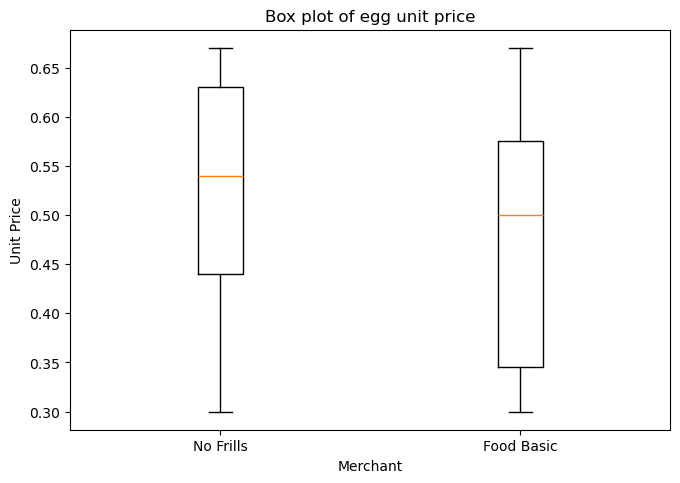

In [11]:
import matplotlib.pyplot as plt

no_frills_egg_unit_price = df[df.merchant == 'No Frills'].unit_price
food_basic_egg_unit_price = df[df.merchant == 'Food Basic'].unit_price

data = [no_frills_egg_unit_price, food_basic_egg_unit_price] 
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)

plt.title("Box plot of egg unit price")
plt.xlabel("Merchant")
plt.ylabel("Unit Price")
plt.xticks([1, 2], ['No Frills', 'Food Basic'])
plt.show()

# Analysis of the unit price between two merchants

In [12]:
# Find is the price of egg is significantly different between different merchants
from scipy import stats

t_stat, p_val = stats.ttest_ind(no_frills_egg_unit_price, food_basic_egg_unit_price)
print('t-value:', t_stat, 'p-value:', p_val)

if p_val < 0.05:
    print('The unit price of egg has significant difference between No Frills and Food Basic')
else:
    print('The unit price of egg has no significant difference between No Frills and Food Basic')


t-value: 1.3349172503654678 p-value: 0.18909470718905788
The unit price of egg has no significant difference between No Frills and Food Basic
